((1000, 5), (1000, 5))

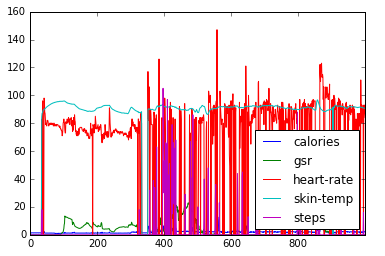

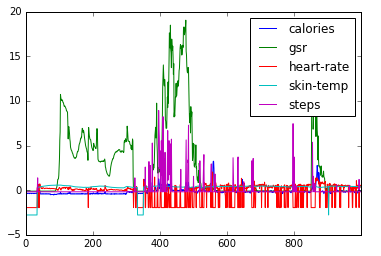

In [3]:
# Data: time-serie data from smartwatch or smartwatch data
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Data reading
# The smartwatch historical/time-seris data to visualize
data_path_1xn = 'data/smartwatch_data/experimental_data_analysis/Basis_Watch_Data.csv'
watch_txn = pd.read_csv(data_path_1xn)

# Data: cleaning
# Getting rid of NaN
watch_txn = watch_txn.fillna(value=0.0)

# # Plotting the smartwatch data before scaling/batch normalization
watch_txn[:1000].plot() #x='dteday', y='cnt'

# Data: Preprocessing 
# Batch normalization
features_1x5 = ['calories', 'gsr', 'heart-rate', 'skin-temp', 'steps']
scaled_features_5x2 = {}
for each_name in features_1x5:
    mean_1x1_val, std_1x1_val = watch_txn[each_name].mean(), watch_txn[each_name].std() # std: standard dev. = square-root of MSE/Variance
    scaled_features_5x2[each_name] = [mean_1x1_val, std_1x1_val]
    watch_txn.loc[:, each_name] = (watch_txn[each_name] - mean_1x1_val)/std_1x1_val

# Drop date from the dataset
watch_txn = watch_txn.drop(labels='date', axis=1)

# ploting the data after scaling or batch normalization
watch_txn[:1000].plot()

# Sequence learning - seq2seq learning - Unsupervised Learning
# Training
X_train = np.array(watch_txn[:-2000])
Y_train = np.array(watch_txn[1:-2000+1])
X_train.shape, Y_train.shape

# Validation
X_valid = np.array(watch_txn[-2000:-1000])
Y_valid = np.array(watch_txn[-2000+1:-1000+1])
X_valid.shape, Y_valid.shape

# Testing
X_test = np.array(watch_txn[-1000:])
Y_test = np.array(watch_txn[-1000+1:])
last_row = np.array([np.zeros_like(Y_test[0])])
Y_test = np.row_stack((Y_test, last_row))
X_test.shape, Y_test.shape

In [13]:
# Model
import impl.loss as loss_fun
import impl.layer as l
import impl.utils as util
import impl.NN as nn

class RNN(nn.NN):

    def __init__(self, D, H, L):
        self.D = D
        self.H = H
        self.L = L
        self.losses = {'train':[], 'valid':[], 'test':[]}
#         self.predictions = []
        super().__init__(D, D, H, None, None, loss='cross_ent', nonlin='relu')

    def _init_model(self, D, C, H):
        m = dict(
            Wxh=np.random.randn(D, H) / np.sqrt(D / 2.),
            Whh=np.random.randn(H, H) / np.sqrt(H / 2.),
            Why=np.random.randn(H, D) / np.sqrt(C / 2.),
            bh=np.zeros((1, H)),
            by=np.zeros((1, D))
            )
        self.model = []
        for l in range(self.L):
            self.model.append(m)
            
    def initial_state(self):
        return np.zeros((1, self.H))

    def forward(self, X, h, m):
        Wxh, Whh, Why = m['Wxh'], m['Whh'], m['Why']
        bh, by = m['bh'], m['by']

        hprev = h.copy()

        h, h_cache = l.tanh_forward(X @ Wxh + hprev @ Whh + bh)
        y, y_cache = l.fc_forward(h, Why, by)

        cache = X, Whh, h, hprev, y, h_cache, y_cache, Wxh

        return y, h, cache

    def backward(self, dy, dh, cache):
        X, Whh, h, hprev, y, h_cache, y_cache, Wxh = cache

        dh_next = dh.copy()
        
        # Hidden to output gradient
        dh, dWhy, dby = l.fc_backward(dy, y_cache)
        dh += dh_next
        dby = dby.reshape((1, -1))

        # tanh
        dh = l.tanh_backward(dh, h_cache)

        # Hidden gradient
        dbh = dh
        dWhh = hprev.T @ dh
        dWxh = X.T @ dh
        
        dX = dh @ Wxh.T
        dh = dh @ Whh.T

        grad = dict(Wxh=dWxh, Whh=dWhh, Why=dWhy, bh=dbh, by=dby)
        
        return dX, dh, grad

    def train_forward(self, X_train, h):
        ys, caches = [], []
        h_init = h.copy()
        h = []
        for l in range(self.L):
            h.append(h_init.copy())
            caches.append([])
            
        for X in X_train:
            #             X_one_hot = np.zeros(self.D)
            #             X_one_hot[X] = 1.
            #             y = X_one_hot.reshape(1, -1)
            y = X.reshape(1, -1)
            for l in range(self.L):
                y, h[l], cache = self.forward(y, h[l], self.model[l])
                caches[l].append(cache)
                
            ys.append(y)
            
        return ys, caches

    def l2_regression_NEW(self, y_pred, y_train):
        m = y_pred.shape[0]

        # (F(x)-y)^2: convex as X^2
        data_loss = 0.5 * np.sum((y_pred - y_train)**2) / m
    
        return data_loss

    def dl2_regression_NEW(self, y_pred, y_train):
        m = y_pred.shape[0]

        # (F(x)-y)^2: convex as X^2
        dy = 0.5 * (y_pred - y_train) / m

        return dy

    def loss_function(self, y_train, ys):
        loss, dys = 0.0, []

        for y_pred, y in zip(ys, y_train):
            loss += self.l2_regression_NEW(y_pred, y)/ y_train.shape[0]
            dy = self.dl2_regression_NEW(y_pred, y)
            dys.append(dy)
            
        return loss, dys

    def train_backward(self, dys, caches):
        dh, grad, grads = [], [], []
        for l in range(self.L):
            dh.append(np.zeros((1, self.H)))
            grad.append({key: np.zeros_like(val) for key, val in self.model[0].items()})
            grads.append({key: np.zeros_like(val) for key, val in self.model[0].items()})
            
        for t in reversed(range(len(dys))):
            dX = dys[t]
            for l in reversed(range(self.L)):
                dX, dh[l], grad[l] = self.backward(dX, dh[l], caches[l][t])
                for k in grad[0].keys():
                    grads[l][k] += grad[l][k]
                
        return dX, grads
    
    def test(self, X_seed, h, size):
        h_init = h.copy()
        h = []
        for l in range(self.L):
            h.append(h_init.copy())

        ys = []
        y = X_seed.reshape(1, -1)

        for t in range(size): # range(start=0, stop=size, step=1)
            for l in range(self.L):
                y, h[l], cache = self.forward(y, h[l], self.model[l])
            ys.append(y)
            
        return ys

In [14]:
import impl.constant as c
import copy
from sklearn.utils import shuffle as skshuffle

def get_minibatch(X, y, minibatch_size, shuffle=True):
    minibatches = []

    if shuffle:
        X, y = skshuffle(X, y)

    for i in range(0, X.shape[0], minibatch_size):
        X_mini = X[i:i + minibatch_size]
        y_mini = y[i:i + minibatch_size]

        minibatches.append((X_mini, y_mini))

    return minibatches

def adam_rnn(nn, X_train, Y_train, X_valid, Y_valid, X_test, alpha, mb_size, n_iter, print_after):
    minibatches = get_minibatch(X_train, Y_train, mb_size, shuffle=False)

    # Remember: only one minibatch in size of timestep is needed.
    minibatches_valid = get_minibatch(X_valid, Y_valid, mb_size, shuffle=False)
#     minibatches_test = get_minibatch(X_test, Y_test, mb_size, shuffle=False)

    idx = 0
    state = nn.initial_state()
    
    M, R = [], []
    for l in range(nn.L):
        M.append({k: np.zeros_like(v) for k, v in nn.model[0].items()})
        R.append({k: np.zeros_like(v) for k, v in nn.model[0].items()})
        
    beta1 = .9
    beta2 = .999

    for iter in range(1, n_iter + 1):

        # The training to learn the gradients/derivatives
        if idx >= len(minibatches):
            idx = 0
            state = nn.initial_state()

        X_mini, y_mini = minibatches[idx]
        ys, caches = nn.train_forward(X_mini, state)
        loss, dys = nn.loss_function(y_mini, ys)
        _, grads = nn.train_backward(dys, caches)
        nn.losses['train'].append(loss)
        idx += 1

        # The validation step: to validate the training and make sure it is not being overfit or maybe underfit
        X_mini_valid, y_mini_valid = minibatches_valid[0]
        ys_valid, _ = nn.train_forward(X_mini_valid, state)
        loss_valid, _ = nn.loss_function(y_mini_valid, ys_valid)
        nn.losses['valid'].append(loss_valid)
        
#        # Testing can be performed after the training and validation process
#         X_mini_test, _ = minibatches_test[0]
#         ys_test = nn.test(X_mini_test[0], state, size=mb_size)
#         nn.predictions.append(ys_test)


        # Print loss of training and validation
        if iter % print_after == 0:
            print('Iter-{} training loss: {:.4f}'.format(iter, loss))
            print('Iter-{} validation loss: {:.4f}'.format(iter, loss_valid))

        for l in range(nn.L):
            for k in grads[0].keys(): #key, value: items
                M[l][k] = util.exp_running_avg(M[l][k], grads[l][k], beta1)
                R[l][k] = util.exp_running_avg(R[l][k], grads[l][k]**2, beta2)

                m_k_hat = M[l][k] / (1. - beta1**(iter))
                r_k_hat = R[l][k] / (1. - beta2**(iter))

                nn.model[l][k] -= alpha * m_k_hat / (np.sqrt(r_k_hat) + c.eps)
    
    return nn

In [61]:
# hyper parameters
n_iter = 100 # epochs
alpha = 1e-3 # learning_rate
print_after = 1 # print lossof train, valid, or test
time_step = 1000 # width of the model or minibatch size
num_hidden_units = 64 # width of the hidden layers or number of hidden units in hidden layer
num_hidden_layers = 1 # depth or number of hidden layer
num_input_units = X_train.shape[1] # number of input features/dimensions

In [62]:
net = RNN(D=num_input_units, H=num_hidden_units, L=num_hidden_layers)

adam_rnn(nn=net, X_train=X_train, Y_train=Y_train, X_valid=X_valid, Y_valid=Y_valid, X_test=X_test, 
         alpha=alpha, mb_size=time_step, n_iter=n_iter, print_after=print_after)

Iter-1 training loss: 52.5997
Iter-1 validation loss: 44.9206
Iter-2 training loss: 46.0529
Iter-2 validation loss: 39.5566
Iter-3 training loss: 28.7460
Iter-3 validation loss: 36.4086
Iter-4 training loss: 37.3545
Iter-4 validation loss: 34.9288
Iter-5 training loss: 29.5528
Iter-5 validation loss: 32.2983
Iter-6 training loss: 23.4066
Iter-6 validation loss: 30.1577
Iter-7 training loss: 35.9031
Iter-7 validation loss: 27.6759
Iter-8 training loss: 43.2036
Iter-8 validation loss: 25.5314
Iter-9 training loss: 21.9995
Iter-9 validation loss: 23.3021
Iter-10 training loss: 27.2983
Iter-10 validation loss: 20.8107
Iter-11 training loss: 36.3934
Iter-11 validation loss: 18.9032
Iter-12 training loss: 27.7137
Iter-12 validation loss: 17.1414
Iter-13 training loss: 28.4859
Iter-13 validation loss: 15.6234
Iter-14 training loss: 20.9427
Iter-14 validation loss: 14.4547
Iter-15 training loss: 20.3311
Iter-15 validation loss: 13.3567
Iter-16 training loss: 16.6356
Iter-16 validation loss: 12

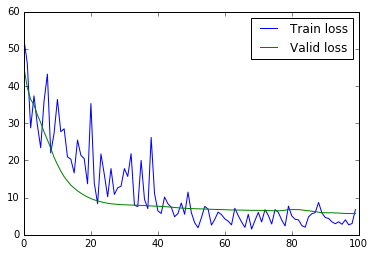

In [63]:
# Display the learning curve and losses for training, validation, and testing
% matplotlib inline
import matplotlib.pyplot as plt

plt.plot(net.losses['train'], label='Train loss')
plt.plot(net.losses['valid'], label='Valid loss')
plt.legend()

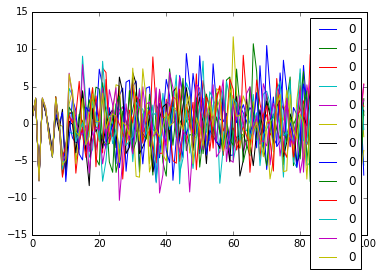

In [9]:
# # Displaying the predictionspred = np.array(net.predictions)
pred = np.array(net.predictions)
for idx in range(13):
    plt.plot(pred[idx, :, :, 0], label='0')
    plt.legend()

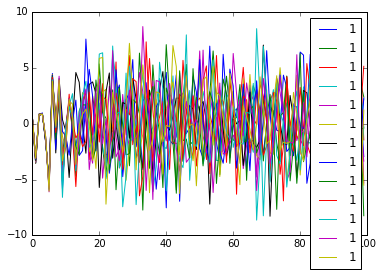

In [10]:
# # Displaying the predictionspred = np.array(net.predictions)
for idx in range(13):
    plt.plot(pred[idx, :, :, 1], label='1')
    plt.legend()

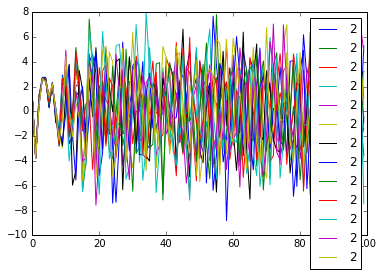

In [11]:
# # Displaying the predictionspred = np.array(net.predictions)
for idx in range(13):
    plt.plot(pred[idx, :, :, 2], label='2')
    plt.legend()

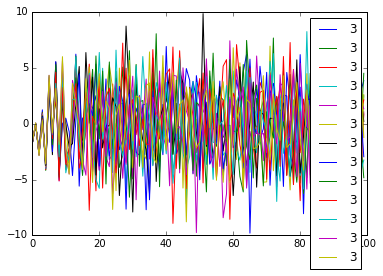

In [12]:
# # Displaying the predictionspred = np.array(net.predictions)
pred = np.array(net.predictions)
for idx in range(13):
    plt.plot(pred[idx, :, :, 3], label='3')
    plt.legend()

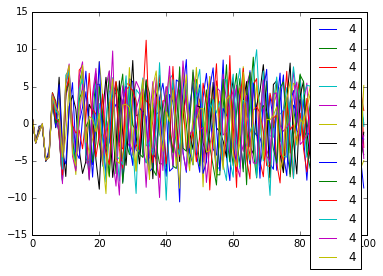

In [13]:
# Displaying the predictionspred = np.array(net.predictions)
pred = np.array(net.predictions)
for idx in range(13):
    plt.plot(pred[idx, :, :, 4], label='4')
    plt.legend()

In [64]:
mb = get_minibatch(X=X_train, y=Y_train, minibatch_size=time_step, shuffle=False)
# len(mb)
X, Y = mb[len(mb)//100]
X.shape, Y.shape
state = net.initial_state()
X_test = net.test(X_seed=X[0], h=state, size=time_step)
# len(X_test)
X_test = np.array(X_test)
X = np.array(X)
X_test.shape, X.shape

((1000, 1, 5), (1000, 5))

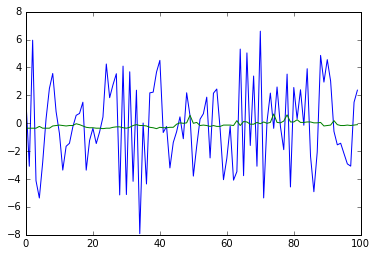

In [66]:
plt.plot(X_test[:100, :, 0], label='X_test')
plt.plot(X[:100, 0], label='X')